In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import fbeta_score, accuracy_score, recall_score, precision_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import json
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
pd.options.display.float_format = '{:,.0f}'.format

In [2]:
# dfreco = pd.read_csv("recommendations.csv")
# dfreco.to_parquet("recommendations.parquet")

In [3]:
dfreco = pd.read_parquet("recommendations.parquet")

In [4]:
dfreco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


In [5]:
dfreco.describe()

app_id    helpful      funny      hours    user_id  review_id
count 41,154,794 41,154,794 41,154,794 41,154,794 41,154,794 41,154,794
mean     603,272          3          1        101  7,450,576 20,577,396
std      472,923         47         29        176  4,010,685 11,880,366
min           10          0          0          0          0          0
25%      253,940          0          0          8  4,287,256 10,288,698
50%      435,150          0          0         27  7,546,446 20,577,396
75%      933,110          0          0         99 10,968,771 30,866,095
max    2,253,290     36,212     28,109      1,000 14,306,063 41,154,793

In [6]:
dfgame = pd.read_csv("games.csv")

In [7]:
dfgame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 non-null  float64
 11  discount        50872 non-null  float64
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.7+ MB


In [8]:
dfgame.describe()

app_id  positive_ratio  user_reviews  price_final  price_original  \
count    50,872          50,872        50,872       50,872          50,872   
mean  1,055,224              77         1,824            9               9   
std     610,325              18        40,074           12              12   
min          10               0            10            0               0   
25%     528,738              67            19            1               1   
50%     986,085              81            49            5               5   
75%   1,524,895              91           206           11              12   
max   2,599,300             100     7,494,460          300             300   

       discount  
count    50,872  
mean          6  
std          19  
min           0  
25%           0  
50%           0  
75%           0  
max          90

In [9]:
dfuser = pd.read_csv("users.csv")

In [10]:
dfuser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 327.4 MB


In [11]:
dfuser.describe()

user_id   products    reviews
count 14,306,064 14,306,064 14,306,064
mean   7,153,032        116          3
std    4,129,805        244          8
min            0          0          0
25%    3,576,516         23          1
50%    7,153,032         55          1
75%   10,729,547        127          3
max   14,306,063     32,214      6,045

In [12]:
dfmeta = pd.read_json('games_metadata.json', lines=True)

In [13]:
dfmeta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_id       50872 non-null  int64 
 1   description  50872 non-null  object
 2   tags         50872 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [14]:
dfmeta.describe()

app_id
count    50,872
mean  1,055,224
std     610,325
min          10
25%     528,738
50%     986,085
75%   1,524,895
max   2,599,300

In [15]:
dfmeta.head()

app_id                                        description  \
0   13500  Enter the dark underworld of Prince of Persia ...   
1   22364                                                      
2  113020  Monaco: What's Yours Is Mine is a single playe...   
3  226560  Escape Dead Island is a Survival-Mystery adven...   
4  249050  Dungeon of the Endless is a Rogue-Like Dungeon...   

                                                tags  
0  [Action, Adventure, Parkour, Third Person, Gre...  
1                                           [Action]  
2  [Co-op, Stealth, Indie, Heist, Local Co-Op, St...  
3  [Zombies, Adventure, Survival, Action, Third P...  
4  [Roguelike, Strategy, Tower Defense, Pixel Gra...

In [16]:
genres = {x for l in dfmeta.tags for x in l}

In [17]:
len(genres)

441

In [19]:
dfuser.sort_values('reviews', ascending=False)

user_id  products  reviews
4803549   11764552      7898     6045
9965497    5112758      1226     4152
13741354  11656130      1807     3840
12041089   5669734      4737     3479
8734053   11553593      1919     3392
...            ...       ...      ...
9221759    2280413        15        0
9221775    2282576        43        0
9221788    2287075        13        0
9221803    2289518         8        0
14306063   5081164         0        0

[14306064 rows x 3 columns]

In [22]:
df = pd.read_csv('secondary_data.csv', sep=';')
df.columns = df.columns.str.replace("-", "_")

In [23]:
def binarize_p_or_e(cls):
    if cls =='p': 
        return True 
    else: 
        return False

In [24]:
df['class'] = df['class'].apply(lambda x: binarize_p_or_e(x))
X = pd.get_dummies(df.drop('class', axis=1))
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [25]:

def get_best_tree(X, y, max_depth=3, random_state=42):
    model = DecisionTreeClassifier(class_weight='balanced', random_state=random_state)
    f2s = {}     
    for i in range(3, max_depth+1):
        model = DecisionTreeClassifier(class_weight='balanced', max_depth=i, splitter='random', random_state=random_state)
        model.fit(X, y)
        y_pred = model.predict(X_test)
        f2s[f"{i}"] = float(recall_score(y_test, y_pred, zero_division=0))

    md = int(max(f2s, key=f2s.get))
    
    print("Best Recall: " + "%f" % f2s[str(md)])
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=md, splitter='random', random_state=random_state) 
    model.fit(X, y)
    return model


model = get_best_tree(X_train, y_train, 100)
model.get_params()
    
    

Best Recall: 1.000000


{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 19,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'random'}

In [26]:
fi = pd.DataFrame(model.feature_importances_, columns=['importance'])
fi['feature'] = X.columns[fi.index]
fi.sort_values(by='importance', ascending=False)[:20]

importance            feature
55    0.054032       gill_color_w
81    0.041793       stem_color_w
57    0.038702        stem_root_b
39    0.036949  gill_attachment_p
17    0.035653      cap_surface_s
36    0.034994  gill_attachment_d
4     0.031448        cap_shape_c
35    0.029724  gill_attachment_a
60    0.028882        stem_root_r
43    0.027206     gill_spacing_d
10    0.024789      cap_surface_d
5     0.024644        cap_shape_f
40    0.024010  gill_attachment_s
58    0.023892        stem_root_c
37    0.022388  gill_attachment_e
90    0.022212         has_ring_f
99    0.020620        ring_type_z
42    0.019425     gill_spacing_c
6     0.019319        cap_shape_o
20    0.018834      cap_surface_y

In [27]:
y_pred = model.predict(X_test)
pd.DataFrame(y_pred).value_counts()

0    
True     10274
False     8047
Name: count, dtype: int64

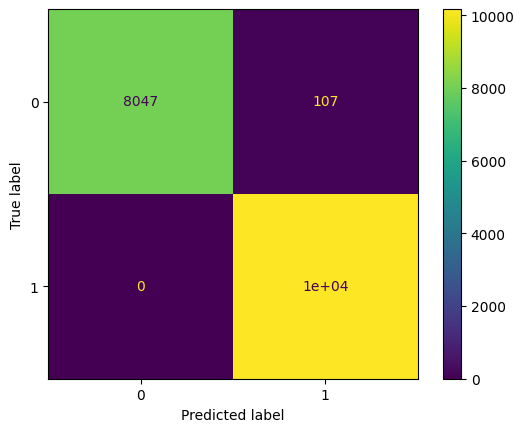

In [28]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [29]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=1)}")
print(f"Recall: {recall_score(y_test, y_pred, zero_division=1)}")
print(f"F2: {fbeta_score(y_test, y_pred, beta=2, zero_division=1)}")

Accuracy: 0.9941597074395503
Precision: 0.9895853611057037
Recall: 1.0
F2: 0.9978995720623454


In [30]:


clf = MLPClassifier(random_state=42, max_iter=300).fit(X_train, y_train)


In [31]:
y_pred = clf.predict(X_test)
pd.DataFrame(y_pred).value_counts()

0    
True     10167
False     8154
Name: count, dtype: int64

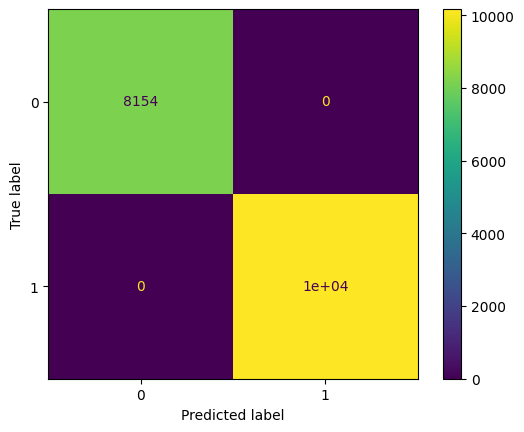

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [33]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=1)}")
print(f"Recall: {recall_score(y_test, y_pred, zero_division=1)}")
print(f"F2: {fbeta_score(y_test, y_pred, beta=2, zero_division=1)}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F2: 1.0


In [36]:
clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [37]:
y_pred = clf.predict(X_test)
pd.DataFrame(y_pred).value_counts()

0    
True     10167
False     8154
Name: count, dtype: int64

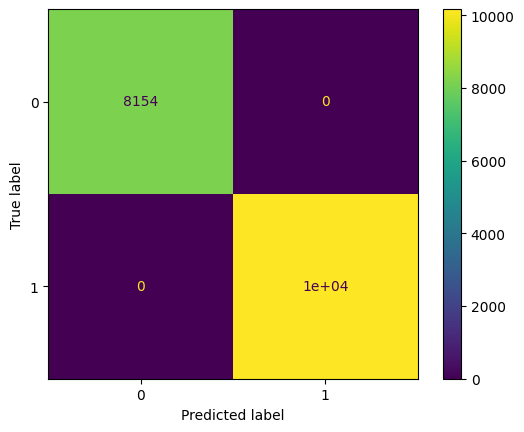

In [38]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [39]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=1)}")
print(f"Recall: {recall_score(y_test, y_pred, zero_division=1)}")
print(f"F2: {fbeta_score(y_test, y_pred, beta=2, zero_division=1)}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F2: 1.0
